# Article Recommendations on IBM Watson Studio

In this notebook, we will investigate the interactions that users have with articles on IBM Watson Studio platform and then provide recommendations of articles that users may like. We will use a series of different recommending techniques that we think will fit different groups of users. For example, new users to the platform will be provided with the most popular articles on the platform, whereas for existing users articles will be recommended based on their viewing history. The content of this notebook is as follows, you can click on a section to jump directly to that section.


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis): basic statistics about the dataset<br>
II. [Rank Based Recommendations](#Rank): most popular articles on the platform<br>
III. [User-User Based Collaborative Filtering](#User-User): recommendation based on similar users' history<br>
IV. [Matrix Factorization](#Matrix-Fact): recommendation based on matrix factorization method<br>
V. [Concluding Remarks](#conclusions): comments and deployment strategy

We will first load the data and look at its content.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head(10)

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2
5,1432.0,visualize data with the matplotlib library,b32cd4e1a74e55ac42e4ef484b1f0ad41ee3b1c5
6,1429.0,use deep learning for image classification,3c2de1b0a92728aa53064a22ff7bd7319878ed95
7,593.0,upload files to ibm data science experience us...,3bbca9c41c66c4ecc46bc14eac7b7ab1ab0a5bea
8,1314.0,healthcare python streaming application demo,8b6fb4bbb7a27b336ba35420bf58337d877455c7
9,1185.0,classify tumors with machine learning,35d5799b6ea3ba24f921ed38f7f9a8039ad06ba4


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


We see that we have two data files: `df` contains the information about which user interacted with which article, `df_content` contains information such as name and description of all the articles.

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

`1.` We first look at some basic information about the interactions of users on the platform. 

In [3]:
median_val = df['email'].value_counts().median() 
print("50% of individuals interact with {} articles or fewer.".format(median_val))
max_views_by_user = df['email'].value_counts().max() 
print("The maximum number of user-article interactions by a user is {}.".format(max_views_by_user))

50% of individuals interact with 3.0 articles or fewer.
The maximum number of user-article interactions by a user is 364.


`2.` We check for duplicate articles from the **df_content** dataframe.  

In [4]:
# Find and explore duplicate articles
pd.concat(g for _, g in df_content.groupby("article_id") if len(g) > 1)

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


We see that some articles are recorded repeatedly. We will simply remove the duplicates.

In [5]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset='article_id', keep='first', inplace=True)

`3.` We look at some more information about the articles, users, and their interactions in this dataset

In [6]:
unique_articles = df['article_id'].nunique() 
print("The number of unique articles that have at least one interaction is {}.".format(unique_articles))
total_articles = df_content['article_id'].nunique() 
print("The number of unique articles on the IBM platform is {}.".format(total_articles))
unique_users = df['email'].nunique() 
print("The number of unique users is {}.".format(unique_users))
user_article_interactions = df.shape[0]
print("The number of user-article interactions is {}.".format(user_article_interactions))

The number of unique articles that have at least one interaction is 714.
The number of unique articles on the IBM platform is 1051.
The number of unique users is 5148.
The number of user-article interactions is 45993.


`4.` We look at the most viewed **article_id**, as well as how often it was viewed.  According to the dataset company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [7]:
most_viewed_article_id = str(df.groupby(['article_id']).size().sort_values(ascending=False).idxmax())
print("The most viewed article in the dataset has article ID {}.".format(most_viewed_article_id)) 
max_views = df.groupby(['article_id']).size().sort_values(ascending=False).max()
print("The most viewed article in the dataset was viewed {} times.".format(max_views))

The most viewed article in the dataset has article ID 1429.0.
The most viewed article in the dataset was viewed 937 times.


In [8]:
# This cell maps the user email to a user_id column and removes the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

In this section, we will write functions to pull out the most popular articles on the platform so that we can recommend those articles to new users. Specifically, in this dataset, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` We prepare the functions below to return the **n** top articles ordered with most interactions as the top.

In [9]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    ''' 
    top_articles = list(df.groupby(['title']).size().nlargest(n).sort_values(ascending=False).index)
    return top_articles 

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(df.groupby(['article_id']).size().nlargest(n).sort_values(ascending=False).index)
    top_articles = [str(i) for i in top_articles]
    return top_articles # Return the top article ids

`2.` Using the existing functions, we can provide the top 10 recommended articles we would provide for the a new user below. Since a new user has no interaction with any of the articles, we will provide him or her with the most popular articles in the platform.

In [17]:
new_user = '0.0'

new_user_recs = get_top_articles(10) # Our recommendations here
print(new_user_recs)

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>

In this section, we will write functions to recommend articles to existing users based on the history of similar users. For instance, if user A interacts mostly with articles 1,2,3, and user B interacts mostly with articles 1,2,3,4, then it's likely that user A will also be intersted in article 4. We will therefore recommend articles 4 to user A. 

`1.` We write the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns, i.e., building a user-article matrix. 

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 


In [11]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    df_work = df.copy()
    df_work['interacted'] = 1
    user_item = df_work.groupby(['user_id','article_id'])['interacted'].max().unstack(fill_value=0)
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

`2.` We write the function below which takes a user_id and provides an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it makes sense to compute similarity as the dot product of two users. 


In [12]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # delete the row with user_id
    new_user_item_matrix = user_item.drop(user_id)
    user_id_articles = user_item.loc[user_id,:]
    # compute similarity of each user to the provided user
    similarity_matrix = new_user_item_matrix.apply(lambda row: np.dot(user_id_articles,row),axis=1)
    most_similar_users = list(similarity_matrix.sort_values(ascending=False).index)
    
       
    return most_similar_users # return a list of the users in order from most to least similar

`3.` Now that we have a function that provides the most similar users to each user, we will want to use these users to find articles we can recommend.  We write the functions below to return the articles we would recommend to each user. 

In [13]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = list(df.loc[df['article_id'].isin(article_ids)]['title'].drop_duplicates().values)
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = list(user_item.loc[user_id, user_item.loc[user_id,:] == 1].index)
    article_ids = [str(i) for i in article_ids]
    article_names = get_article_names(article_ids)
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''

    recs = np.array([])
    
    article_seen_ids, article_seen_names = get_user_articles(user_id)
    similar_users = find_similar_users(user_id)
    for user in similar_users:
        similar_user_articles_id, _ = get_user_articles(user)
        new_recs = np.setdiff1d(similar_user_articles_id, article_seen_ids, assume_unique=True)
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))
        if len(recs) > m-1:
            recs = recs[:m]
            break
    
    return recs # return your recommendations for this user_id    

In [14]:
# Check Results
get_article_names(user_user_recs(20, 10)) # Return 10 recommendations for user 20

['analyze energy consumption in buildings',
 'apache spark lab, part 3: machine learning',
 'analyze precipitation data',
 'analyze accident reports on amazon emr spark',
 'tidy up your jupyter notebooks with scripts',
 'tensorflow quick tips',
 'airbnb data for analytics: vienna listings',
 'machine learning for the enterprise.',
 'essentials of machine learning algorithms (with python and r codes)',
 'building custom machine learning algorithms with apache systemml']

`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function we wrote earlier.

In [15]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''

    new_user_item_matrix = user_item.drop(user_id)
    user_id_articles = user_item.loc[user_id,:]
    similarity_matrix = new_user_item_matrix.apply(lambda row: np.dot(user_id_articles,row),axis=1)
    similarity_matrix_df = similarity_matrix.sort_values(ascending=False).to_frame(name='similarity')
    
    num_interaction = df.groupby(['user_id']).size().to_frame(name='num_interactions')
    
    neighbors_df = similarity_matrix_df.join(num_interaction,on='user_id')
    neighbors_df.sort_values(by=['similarity','num_interactions'],ascending=False,inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    recs = np.array([])
    rec_names = np.array([])
    
    article_seen_ids, article_seen_names = get_user_articles(user_id)
    similar_users = get_top_sorted_users(user_id).index
    for user in similar_users:
        similar_user_articles_id, _ = get_user_articles(user)
        new_recs = np.setdiff1d(similar_user_articles_id, article_seen_ids, assume_unique=True)
        new_recs_sorted = df.loc[df['article_id'].isin(new_recs)].groupby(['article_id']).size().sort_values(ascending=False).index.values
        new_rec_names = get_article_names(new_recs_sorted)
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))
        rec_names = np.unique(np.concatenate([new_rec_names, rec_names], axis=0))
        if len(recs) > m-1:
            recs = recs[:m]
            rec_names = rec_names[:m]
            break
            
    return recs, rec_names

In [16]:
# Quick spot check 
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1024.0' '1085.0' '109.0' '1150.0' '1151.0' '1152.0' '1153.0' '1154.0'
 '1157.0' '1160.0']

The top 10 recommendations for user 20 are the following article names:
['10 powerful features on watson data platform, no coding necessary'
 "a beginner's guide to variational methods"
 'accelerate your workflow with dsx'
 'airbnb data for analytics: chicago listings'
 'airbnb data for analytics: venice calendar'
 'airbnb data for analytics: venice listings'
 'airbnb data for analytics: venice reviews'
 'airbnb data for analytics: vienna calendar'
 'airbnb data for analytics: vienna listings'
 'airbnb data for analytics: washington d.c. listings']


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, we will use matrix factorization to make article recommendations to existing users on the IBM Watson Studio platform.

`1.`We first take a look again at the `user_item` matrix

In [18]:
# quick look at the matrix
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` In this situation, we use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  

In [19]:
u, s, vt = np.linalg.svd(user_item)

Note that we can safely user SVD here since our user_item matrix has no missing value, i.e., we know for sure which user interacted with which articles.

`3.` Now the question is, how do we choose the number of latent features to use? Through the below cell, we can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix, i.e., the pridiction accuracy increases.

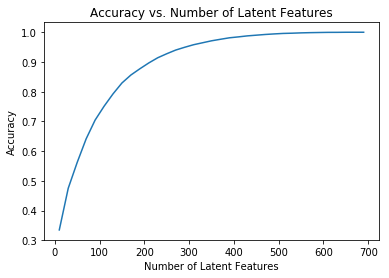

In [20]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above graph, however, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data.  

In [33]:
df_train = df.head(30000)
df_test = df.tail(15993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

However, an important remark here is that we need to check how many users we can make predictions for in the test set. We can only provide such predictions if users **exist** in both training and testing dataset. If there are users that in the test set but not in the training set, we cannot make prediction for those users. This is called the *cold start* problem. 

In [41]:
common_users = user_item_train[user_item_train.index.isin(user_item_test.index)]
print('The number of common users that are in both training and testing sets are {}.'.format(common_users.shape[0]))
print('The number of users that we can provide predictions for is {} out of {} users.'.format(common_users.shape[0],user_item_test.shape[0]))
print('The number of users in the test set that we are not able to make predictions for because of the cold start problem are {}.'.format(user_item_test.shape[0]-common_users.shape[0]))

The number of common users that are in both training and testing sets are 13.
The number of users that we can provide predictions for is 13 out of 1679 users.
The number of users in the test set that we are not able to make predictions for because of the cold start problem are 1666.


Similarly, we need to check how many articles we can make predictions for in the test set. We can only provide such predictions if an article exists in both training and testing dataset. If there are articles that in the test set but not in the training set, we cannot make prediction for those articles. 

In [43]:
common_articles = user_item_train.loc[:,user_item_train.columns.isin(user_item_test.columns)]
print('The number of common articles that are in both training and testing sets are {}.'.format(common_articles.shape[1]))
print('The number of articles that we can provide predictions for is {} out of {} articles.'.format(common_articles.shape[1],user_item_test.shape[1]))
print('The number of articles in the test set that we are not able to make predictions for because of the cold start problem are {}.'.format(user_item_test.shape[1]-common_articles.shape[1]))

The number of common articles that are in both training and testing sets are 671.
The number of articles that we can provide predictions for is 671 out of 671 articles.
The number of articles in the test set that we are not able to make predictions for because of the cold start problem are 0.


We see that we can provide recommendations for all articles but only 13 users in the test set.

`5.`  Now we can use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. 

In [36]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) 

Now, to provide prediction, we need to find the indices in the training set of the common users and the common articles. Next, we calculate the dot product of the three matrices found by SVD of the `user_item_train` matrix with a given number of laten features. We then can compare our predictions with the `user_item_test` matrix to see how well we are doing. The following function plot the accuracy of our prediction as a function of the number of latent features used.

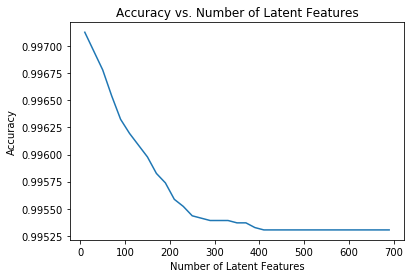

In [38]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    #user_ids of the common users
    common_users_index = common_users.index
    user_ids_in_train = [user_item_train.index.get_loc(c) for c in common_users_index if c in user_item_train.index]
    
    articles_in_test_set = user_item_test.columns
    article_ids_in_train = [user_item_train.columns.get_loc(c) for c in articles_in_test_set if c in user_item_train]
    
    user_item_est_subset = user_item_est[user_ids_in_train, :][:,article_ids_in_train]
    user_item_test_subset = user_item_test[user_item_test.index.isin(common_users_index)]
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test_subset, user_item_est_subset)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');


Looking at the graph, we see that the accuracy is very high even though we use a large number of latent features. It is because we can provide prediction for only 13 out of 1,679 users. Due to a large number of users that are on the test set but not in the dataset, we should deploy this matrix factorization-based recommendation online to evaluate its performace more accurately. 

<a id='conclusions'></a>

## Concluding Remarks

In this notebook, we examined different ways to provide recommendations of articles for users on the IBM Watson Studio paltform. For new users, we used rank-based recommendation to provide them with the most popular articles on the platform. For existing users, we provided them with articles that their most similar colleagues like and mostly interact with. We also presented a matrix factorization-based recommendation system that can be deployed online to provide recommendation for existing users. Using our models from this project, we can increase user interaction with IBM Watson Studio platform. Our models can also be easily transferred to similar platform such as online forums. 